In [57]:
#This assignment will use MNIST data to build an active learning model
#We will use the entire MNIST data set, with an 80/20 split for training and testing


#references
1#ttps://en.wikipedia.org/wiki/Active_learning_(machine_learning)


1

In [58]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from graphviz import Digraph

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor


from IPython.display import Image

from datetime import datetime

In [59]:

#check data path
data_path = '/../data/mnist/'


mnist_data_file = 'mnist_full_784.npy'
mnist_labels_file = 'mnist_full_labels_784.npy'


if os.path.exists(os.getcwd() + data_path + mnist_data_file):
    X = np.load(os.getcwd() + data_path + mnist_data_file, allow_pickle=True)

if os.path.exists(os.getcwd() + data_path + mnist_labels_file):
    y = np.load(os.getcwd() + data_path + mnist_labels_file, allow_pickle=True)


The active learning algorithm has the following psuedocode  

Input: Dl, Du, h  
Output: h  

Psuedocode from paper
1) Train h using Dl
2) While stopping conditions not met Do  
    1) For each instance Xi in Du  
        1) ui = u(Xi, h)  
    1) End for  
    1) i* = argmax(ui, i)
    2) x* = xi*
    3) y* = query(x*)
    4) Dl = Dl union (x*, y*)
    5) Du = Du subtract x*
    6) Update h based on new Dl
9) End while

My interpretation
utility_value(x) returns the utility value of point x

1) confusion_matrices = []
1) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
1) Dl = empty list
2) Dl.append(choose_first_point(X,y))
2) model = active_learn.fit(Dl)
2) confusion_matrices.append(model)
3) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
3) while not stopping_condition
    3) utility_scores = [utility_value(x) for x in Du]
    3) best_utility_index = argmax(utility_scores)
    4) Dl.append(X_train[best_utility_index], y_train[best_utility_index])
    4) Du.remove(X_train[best_utility_index], y_train[best_utility_index])
    5) model = active_learn.fit(Dl)
    5) confusion_matrices.append(model)
    6) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)    
4) Generate graphs

@article{tharwat2023survey,
  title={A survey on active learning: state-of-the-art, practical challenges and research directions},
  author={Tharwat, Alaa and Schenck, Wolfram},
  journal={Mathematics},
  volume={11},
  number={4},
  pages={820},
  year={2023},
  publisher={MDPI}
}

<https://doi.org/10.3390/math11040820>

In [60]:
class active_model_learning():
    def __init__(self, model, X, y, X_test=None, y_test=None, accuracy_threshold=0.95, max_iterations=1000, verbose=True, random_state=42, test_size=0.2, strategy_function=None):
        self.model = model
        self.strategy_function = strategy_function
        
        if X_test is None or y_test is None:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            
        self.Du_X = np.array(X_train); self.Du_y = np.array(y_train); self.Du = (self.Du_X, self.Du_y)
        #match the shape of the data, except for the index column which will be 1
        #shape = list(X.shape); shape[0] = 1; shape = tuple(shape)
        self.Dl_X = np.array([]); self.Dl_y = np.array([]); self.Dl = (self.Dl_X, self.Dl_y)              
        
        self.confusion_matrices = []
        self.calculable_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": [], "pr_auc": []}
        self.accuracy_threshold = accuracy_threshold
        self.accuracy_threshold_reached = False
        self.max_iterations = max_iterations
        self.current_iteration = 0
        self.verbose = verbose
        self.X_test = X_test
        self.y_test = y_test
        self._next_index=0
        
        
        
        
    def _select_point_from_pool(self):
        #place X[index] and y[index] into Dl_X and Dl_y
        if self.Dl_X.shape[0] == 0:
            self.Dl_X = self.Du_X[self._next_index].reshape(1, -1)
            self.Dl_y = np.array([self.Du_y[self._next_index]])
        else:        
            self.Dl_X = np.append(self.Dl_X,self.Du_X[self._next_index].reshape(1, -1), axis=0)
            self.Dl_y = np.append(self.Dl_y, [self.Du_y[self._next_index]], axis=0)
        
        #remove X[index] and y[index] from Du_X and Du_y
        self.Du_X = np.delete(self.Du_X, self._next_index, axis=0)
        self.Du_y = np.delete(self.Du_y, self._next_index, axis=0)
    
    def _train_model(self):
        if self.verbose:
            print(f"Training model on {len(self.Dl_X)} points. Iteration {self.current_iteration} at {datetime.now()}")
            start_time = datetime.now()
            
        self.model.fit(self.Dl_X, self.Dl_y)
        
        if self.verbose:
            print(f"Training time: {datetime.now() - start_time}")
        
    def test_model(self, X, y):
        y_pred = self.model.predict(X)
        self.confusion_matrices.append(confusion_matrix(y, y_pred))
        
        if self.verbose:
            print(f"Confusion matrix for iteration {self.current_iteration}: {self.confusion_matrices[-1]}")
            
    def _test_model(self):            
        self.test_model(self.X_test, self.y_test)        
        
    def evaluate_model(self, X, y):
        self.test_model(X, y)
        
        fp = (self.confusion_matrices[-1].sum(axis=0) - np.diag(self.confusion_matrices[-1]))
        fn = (self.confusion_matrices[-1].sum(axis=1) - np.diag(self.confusion_matrices[-1]))
        tp = np.diag(self.confusion_matrices[-1])
        tn = self.confusion_matrices[-1].sum() - (fn + tp + fn)
        
        accuracy = (tp + tn) / (tp + tn + fn + fp)
        self.calculable_metrics["accuracy"].append(accuracy)
        self.calculable_metrics["precision"].append(tp / (tp + fp))
        self.calculable_metrics["recall"].append(tp / (tp + fn))   
        self.calculable_metrics["f1"].append(2 * (self.calculable_metrics["precision"][-1] * self.calculable_metrics["recall"][-1]) / (self.calculable_metrics["precision"][-1] + self.calculable_metrics["recall"][-1]))
        #self.calculable_metrics["roc_auc"].append(roc_auc_score(y, self.model.predict_proba(X)))
        #self.calculable_metrics["pr_auc"].append(auc(*precision_recall_curve(y, self.model.predict_proba(X))[:2]))        
        
        if self.verbose:
            print(f"Accuracy for iteration {self.current_iteration}: {accuracy}")
            
        if accuracy.min() >= self.accuracy_threshold:
            self.accuracy_threshold_reached = True
            if self.verbose:
                print(f"Accuracy threshold reached at iteration {self.current_iteration}")
        return accuracy

    def _evaluate_model(self):
        return self.evaluate_model(self.X_test, self.y_test)
        
    def utility_function(self, X):
        #return the point with the highest uncertainty
        if self.strategy_function is None:
            #check if the model has a predict_proba method
            if not hasattr(self.model, "predict_proba"):
                array = np.zeros(X.shape[0])
                array[np.random.randint(0, X.shape[0])] = 1
                return array                
                
            return self.model.predict_proba(X)
        else:
            return self.strategy_function(self, X)
    
    def utility_function_index(self, X):
        #return the point with the highest uncertainty
        return np.argmax(self.utility_function(X))
    
    def _utility_function_index(self):
        #return the point with the highest uncertainty
        self._next_index = np.argmax(self.utility_function(self.Du_X))
        
        if self._next_index >= self.Du_X.shape[0]:
            if self.verbose:
                print(f"Index out of range: {self._next_index}")
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            
        if self.verbose:
            print(f"Selected index {self._next_index} for iteration {self.current_iteration}")
        return self._next_index
    
    def _run_next(self):
        self.current_iteration += 1
        if self.accuracy_threshold_reached:
            return False
        if self.current_iteration >= self.max_iterations:
            return False
        return True
    
    def report(self):
        print(f"Final accuracy: {self.evaluate_model(self.X_test, self.y_test)}")
        print(f"Final confusion matrix: {self.confusion_matrices[-1]}")
        print(f"Final iteration: {self.current_iteration}")
        print(f"Final accuracy threshold reached: {self.accuracy_threshold_reached}")
    
    def generate_graphs(self):
        #add 5 confusion matrices images into the main plot as insets
        figs = []
        axes = []
        
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        figs.append(fig)
        axes.append(ax)
        indices_to_plot = np.linspace(1, len(self.confusion_matrices), 5).astype(int)
                
        for i in range(5):
            ax[i].imshow(self.confusion_matrices[indices_to_plot[i]-1])
            ax[i].set_title(f"Confusion matrix {indices_to_plot[i]}")
        fig.suptitle(f"Confusion matrices for {self.model.__class__.__name__}")
        fig.show()      
        
        fig, ax = plt.subplots(figsize=(20, 20))
        figs.append(fig)
        axes.append(ax)
        ax.plot(self.calculable_metrics["accuracy"], label=np.unique(self.Du_y))
        ax.set_title(f"Accuracy over iterations {self.model.__class__.__name__}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Accuracy")                    
        plt.show()
        
        fig, ax = plt.subplots(figsize=(20, 20))
        figs.append(fig)
        axes.append(ax)
        ax.plot(np.average(np.array(self.calculable_metrics["accuracy"]),axis=1))
        ax.set_title(f"Average accuracy over iterations {self.model.__class__.__name__}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Accuracy")
        #add confusion matrix images into the main plot as insets
        #MARK: add confusion matrix images into the main plot as insets
        for i in range(5):
            #ax_inset = fig.add_axes([indices_to_plot[i]-1, indices_to_plot[i]+self.current_iteration/5, 0.4, 0.4 ])
            a=np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]
            b=fig.axes[0].get_ylim()[0] 
            c=fig.axes[0].get_ylim()[1]
            data_point_relative_y_position = (a-b)/(c-b)
            if data_point_relative_y_position > 0.5:
                bottom_position = data_point_relative_y_position - 0.15
            else:
                bottom_position = data_point_relative_y_position + 0.15
            
            ax_inset = fig.add_axes([(i+1)/7, bottom_position,0.1,0.1 ])
            ax_inset.imshow(self.confusion_matrices[indices_to_plot[i]-1])
            ax_inset.set_title(f"Confusion matrix {indices_to_plot[i]}")           
        plt.show()
        
        return figs, axes
    
    
    def run(self):
        #select a point from the pool at random
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()                     
        
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()
        self._train_model()               
        
        while self._run_next():   
            self._utility_function_index()
            self._select_point_from_pool()
            self._train_model()
            self._evaluate_model()
                        
        if self.verbose:
            print(f"Model training complete at iteration {self.current_iteration}")
            
        return self.accuracy_threshold_reached

def random_strategy(obj, X):
    array = np.zeros(X.shape[0])
    array[np.random.randint(0, X.shape[0])] = 1
    return array
    

def uncertainty_strategy(obj, X):
    return 1 - obj.model.predict_proba(X).max(axis=1)







C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid valu

Final accuracy: [0.85353003 0.90359712 0.88639446 0.82888229 0.89800094 0.89997643
 0.83079721 0.88562658 0.89266788 0.88757303]
Final confusion matrix: [[1228    0   12    6    1    0   84   12    0    0]
 [ 110  566   32  449    0    0  217  226    0    0]
 [ 217    5  263   60    0    0  810   24    0    1]
 [ 516   22   54  718    0    0   91   30    0    2]
 [  92   51    2  231    0    0  543  344    0   32]
 [ 704   24   11  321    0    0  132   81    0    0]
 [  71    2    6   66    0    0 1248    3    0    0]
 [  59   67   14   72    0    0  142 1139    0   10]
 [ 429   20  253  309    0    0  258   88    0    0]
 [  50   48    7  366    0    0  366  542    0   41]]
Final iteration: 16
Final accuracy threshold reached: True


C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:147: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


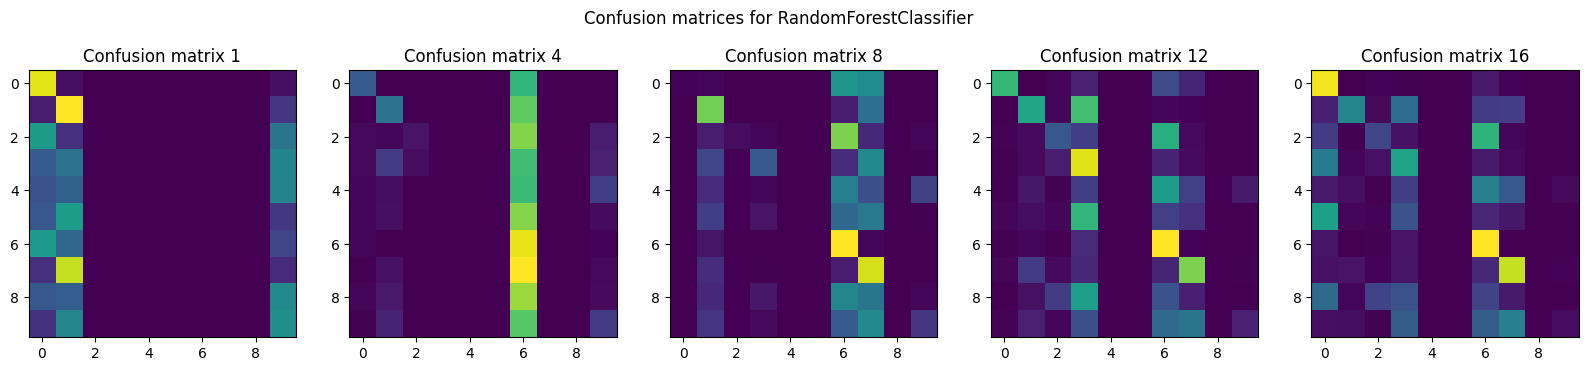

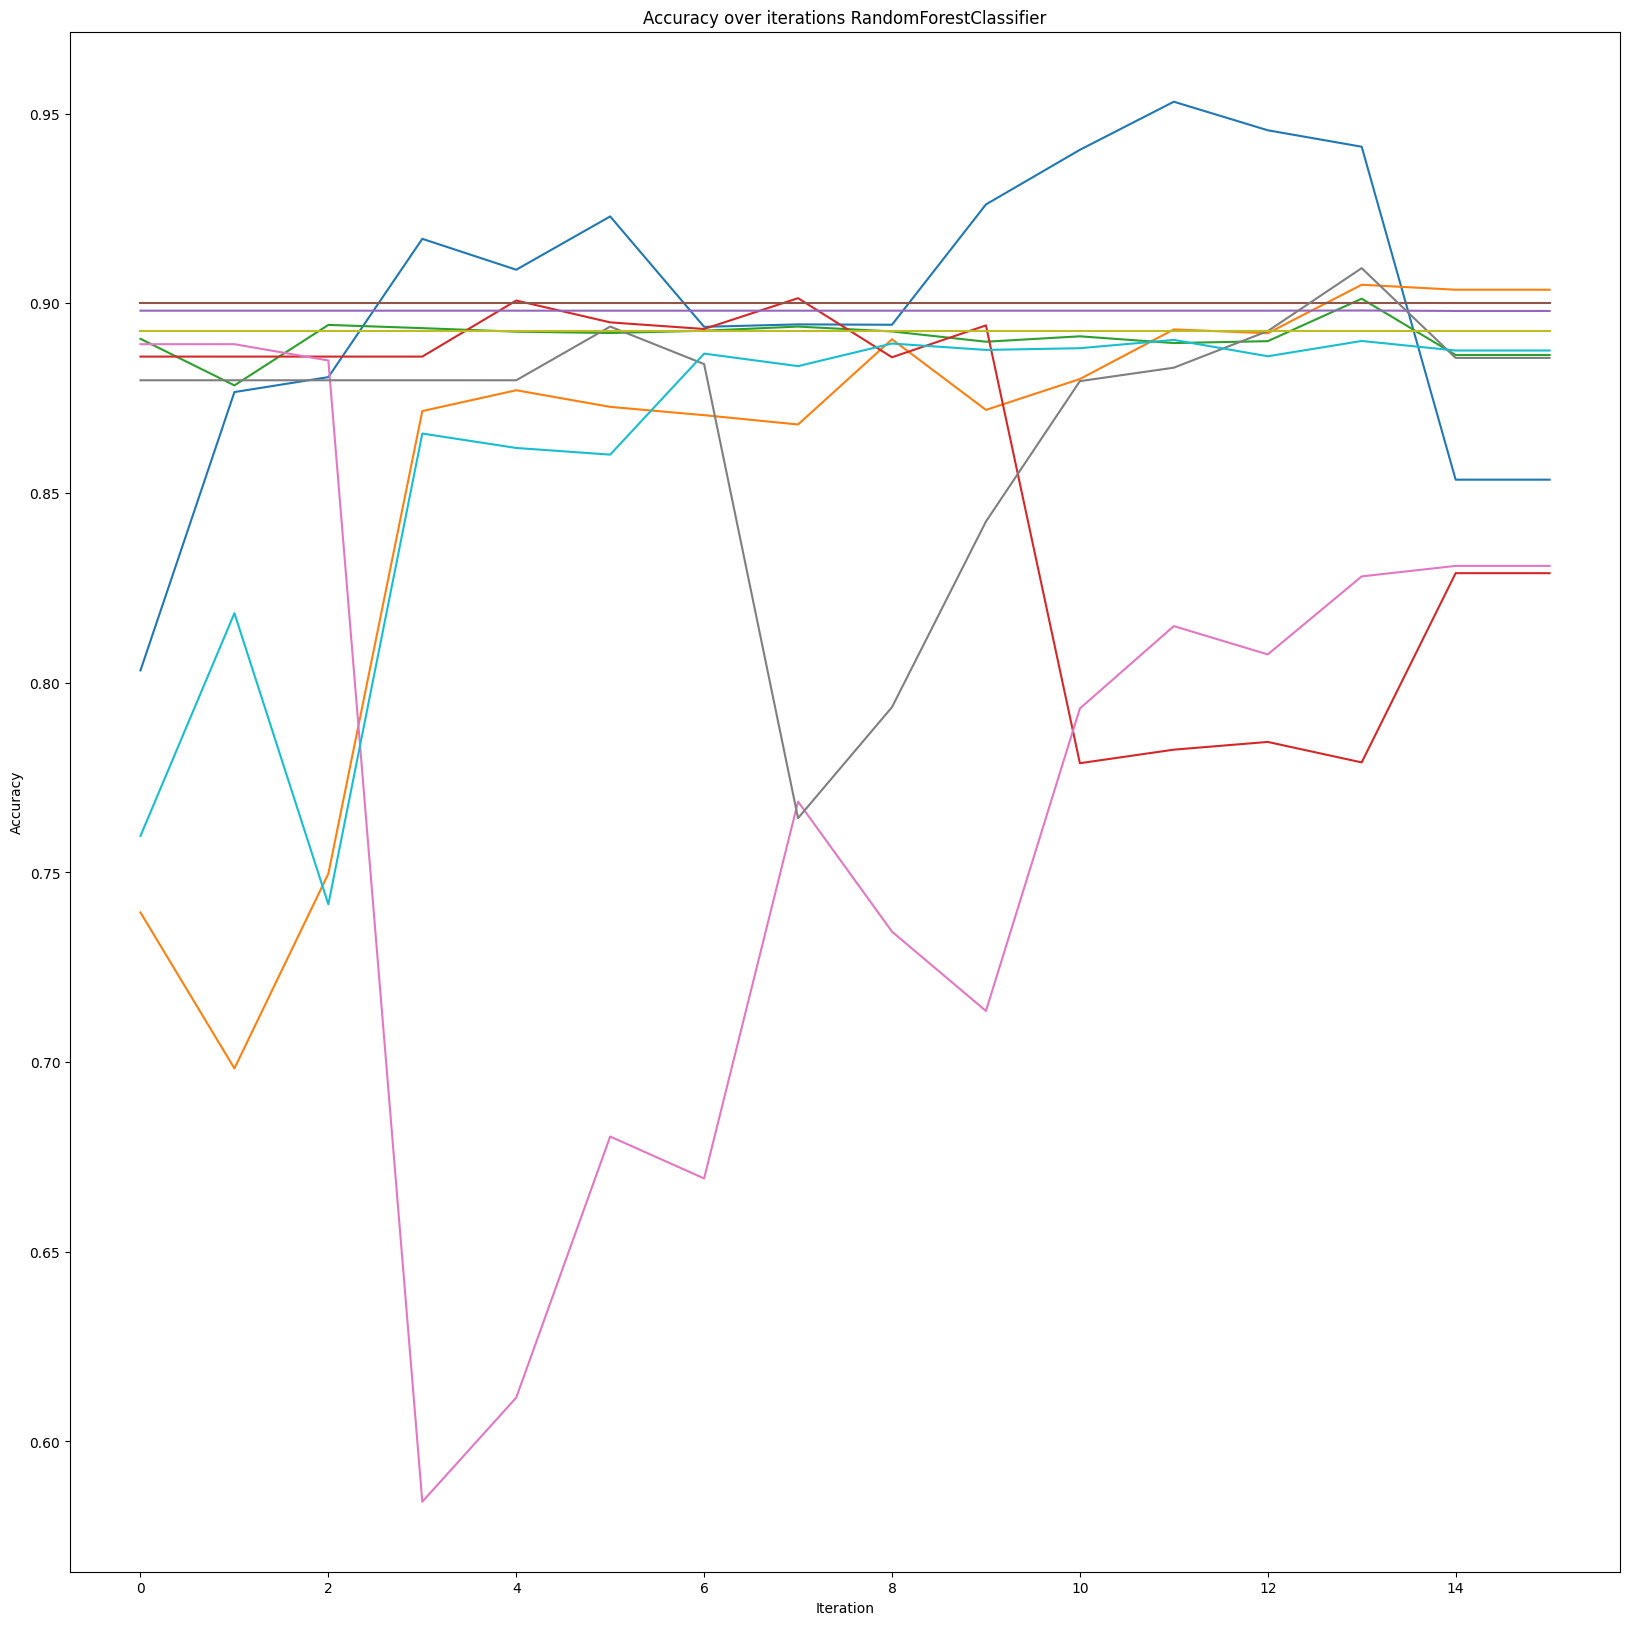

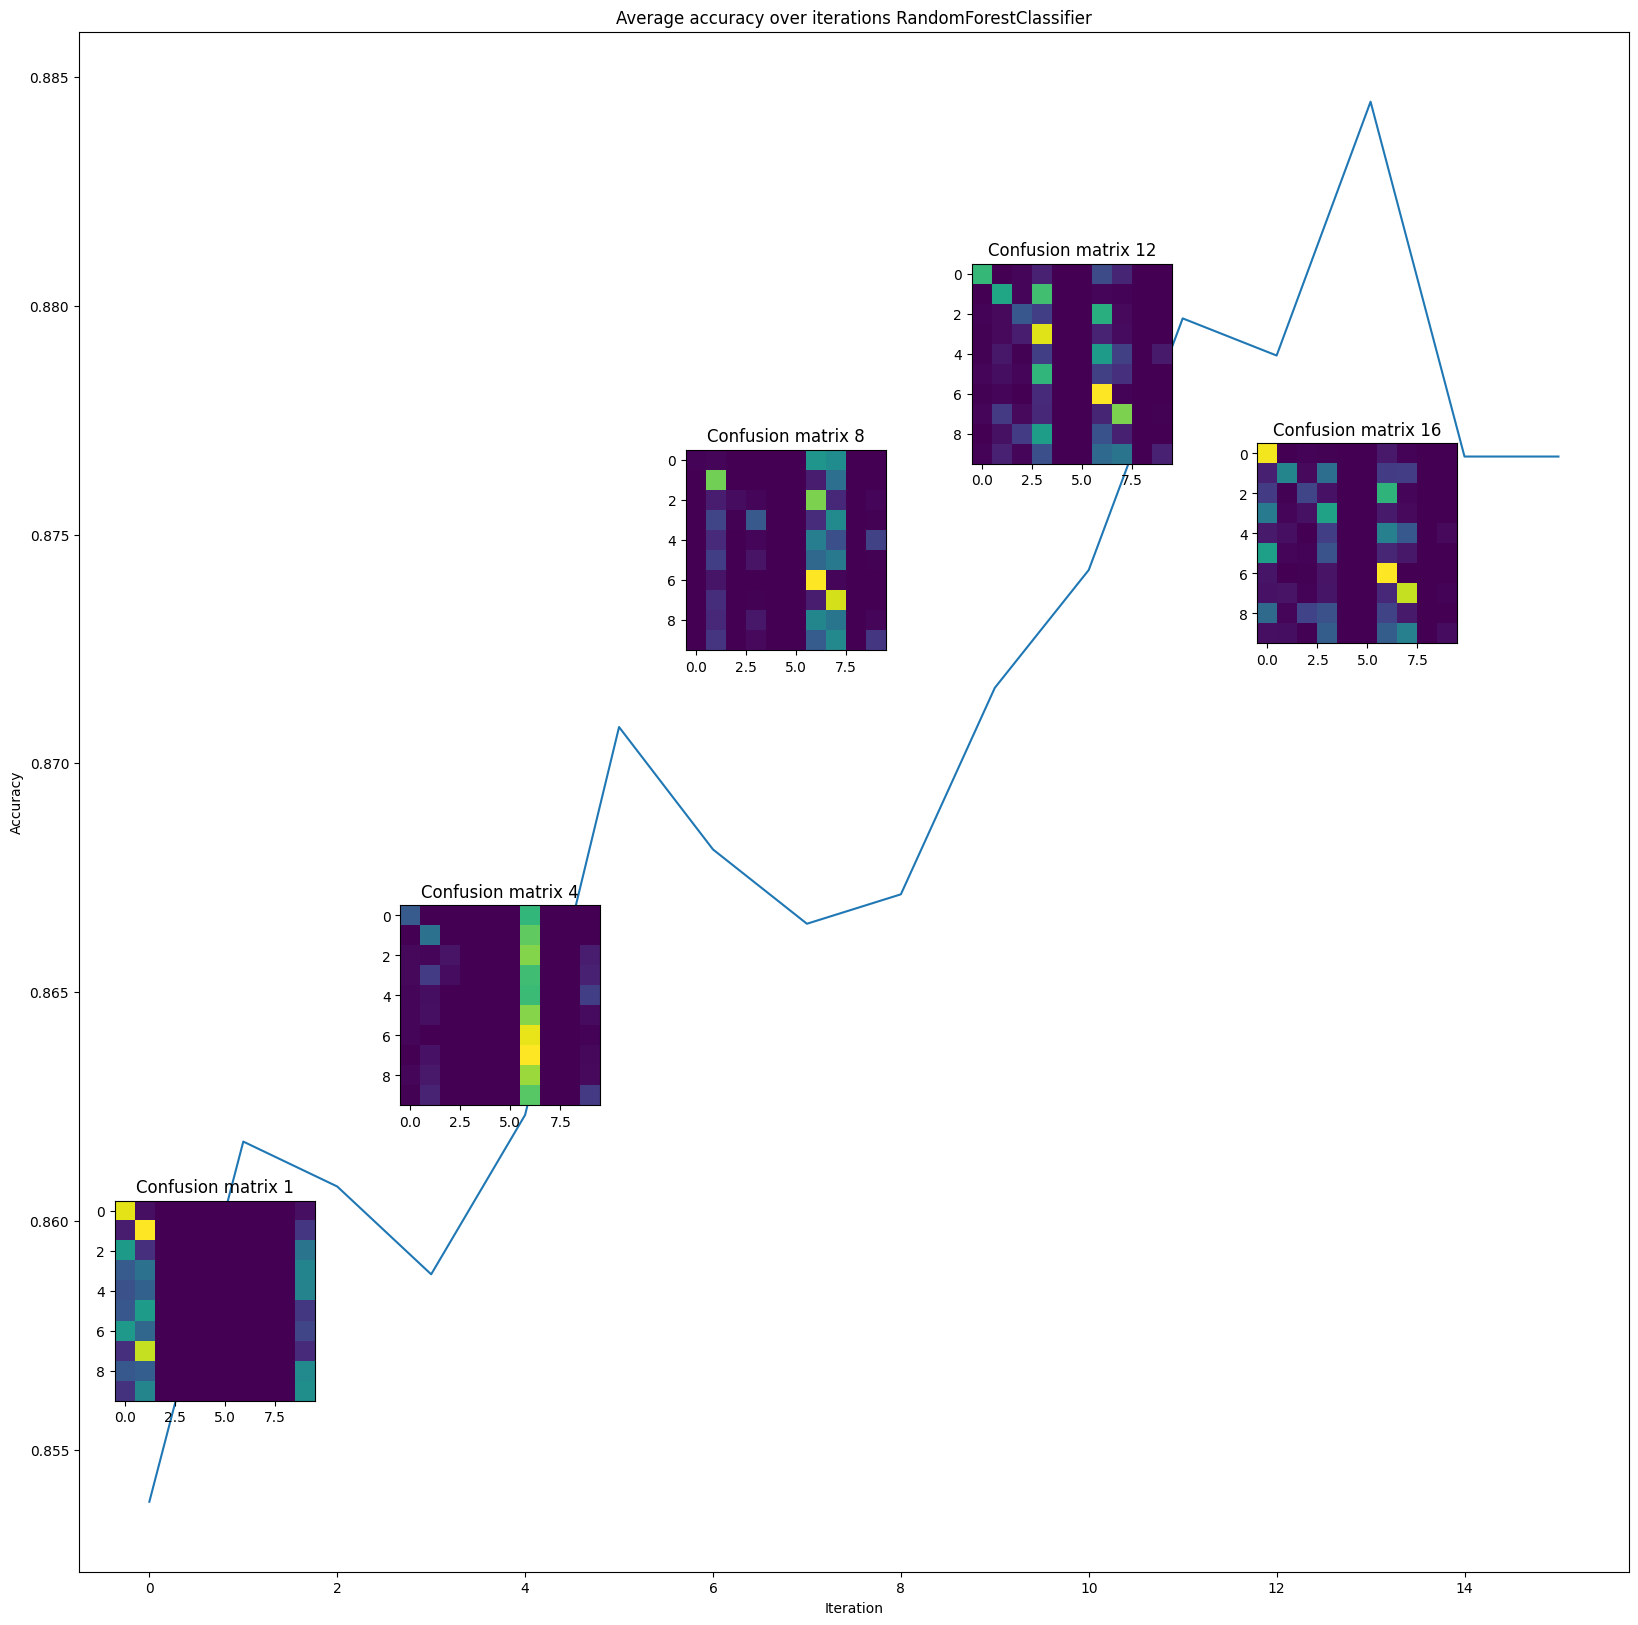

C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid valu

Final accuracy: [0.88187464 0.89492582 0.83415796 0.90269211 0.92213487 0.90831124
 0.89084284 0.90852596 0.87773967 0.86778083]
Final confusion matrix: [[1230    4   95    5    0    0    0    2    7    0]
 [   0 1205   54  106    0    0    0    0    0  235]
 [  39   97 1208   10    3    0    0    4    7   12]
 [ 210  177  343  653    3    0    0    3   30   14]
 [ 198  100  147   24  394    0    1   43  113  275]
 [ 380  136  258  238   16   98    0    1   71   75]
 [ 538   17  807    4    4    0   19    0    1    6]
 [ 123  245   84   19   28    0    0  497  153  354]
 [  84  279  557  127    5    1    0    3  244   57]
 [ 160  101  198   28   70    0    0  145  145  573]]
Final iteration: 23
Final accuracy threshold reached: True


C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:147: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


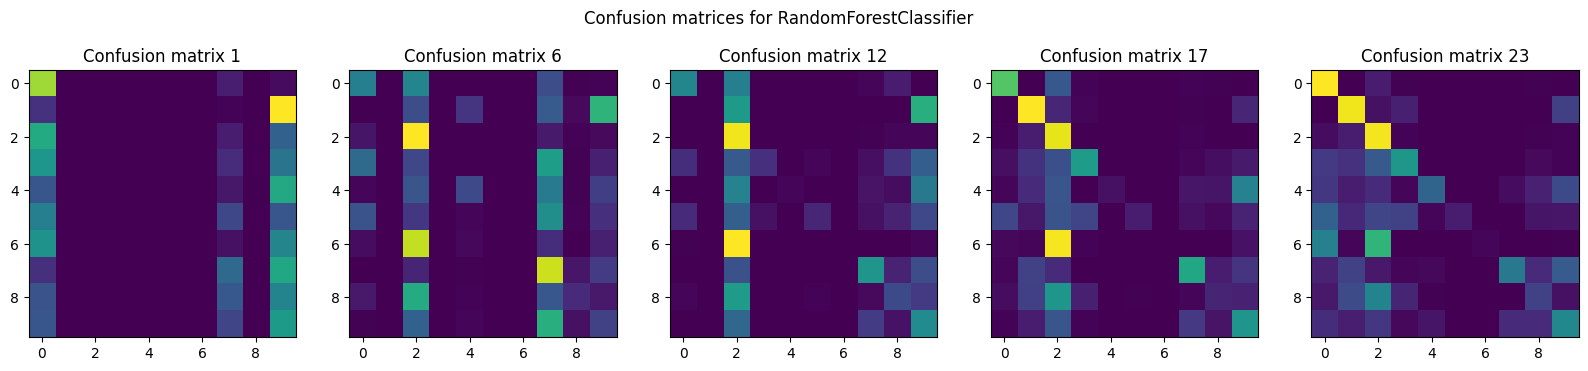

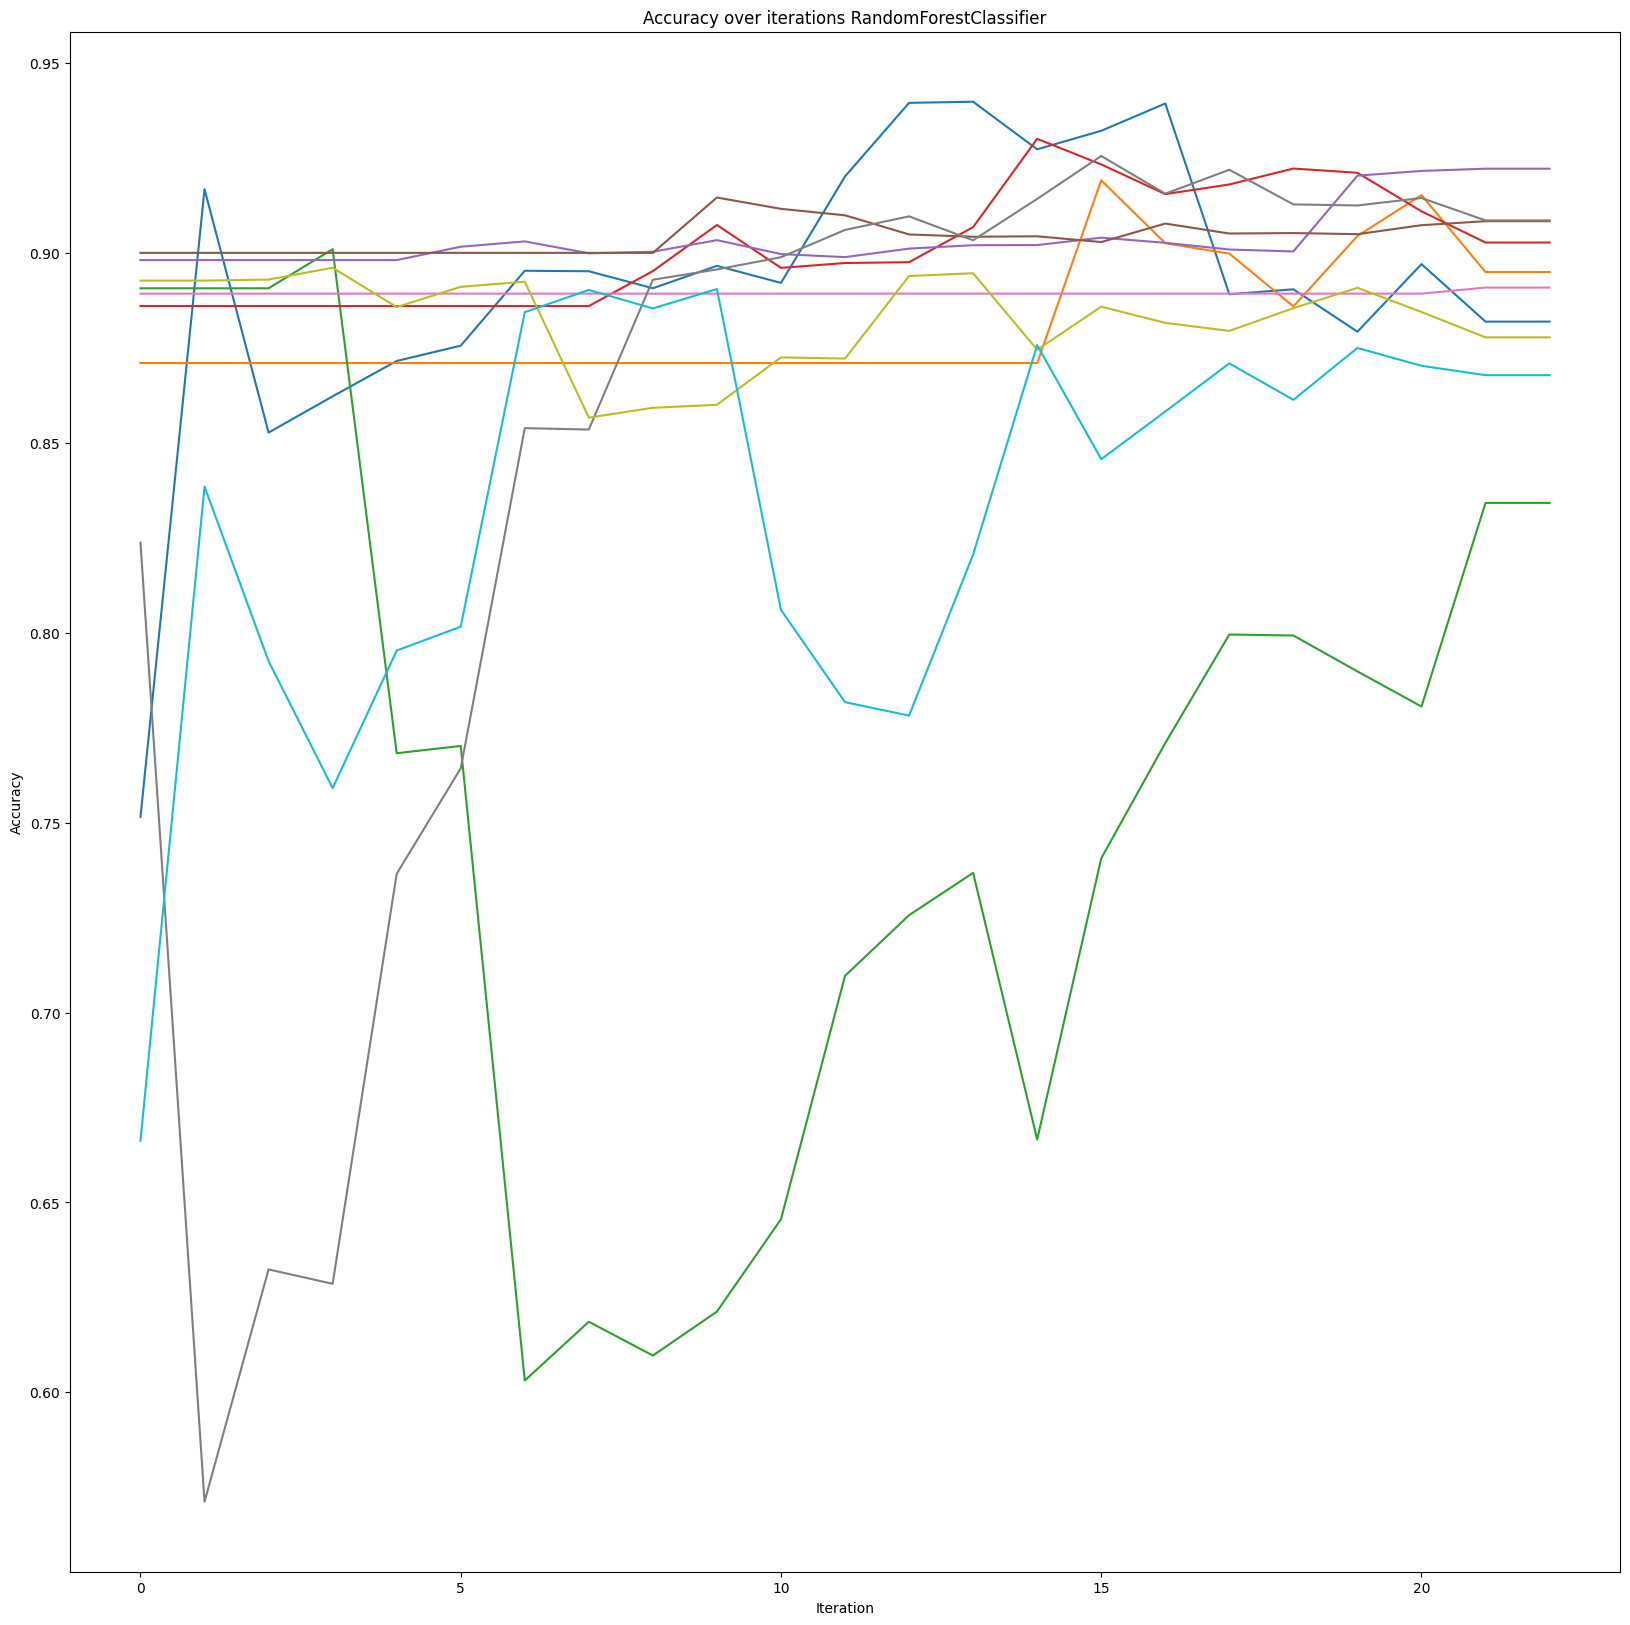

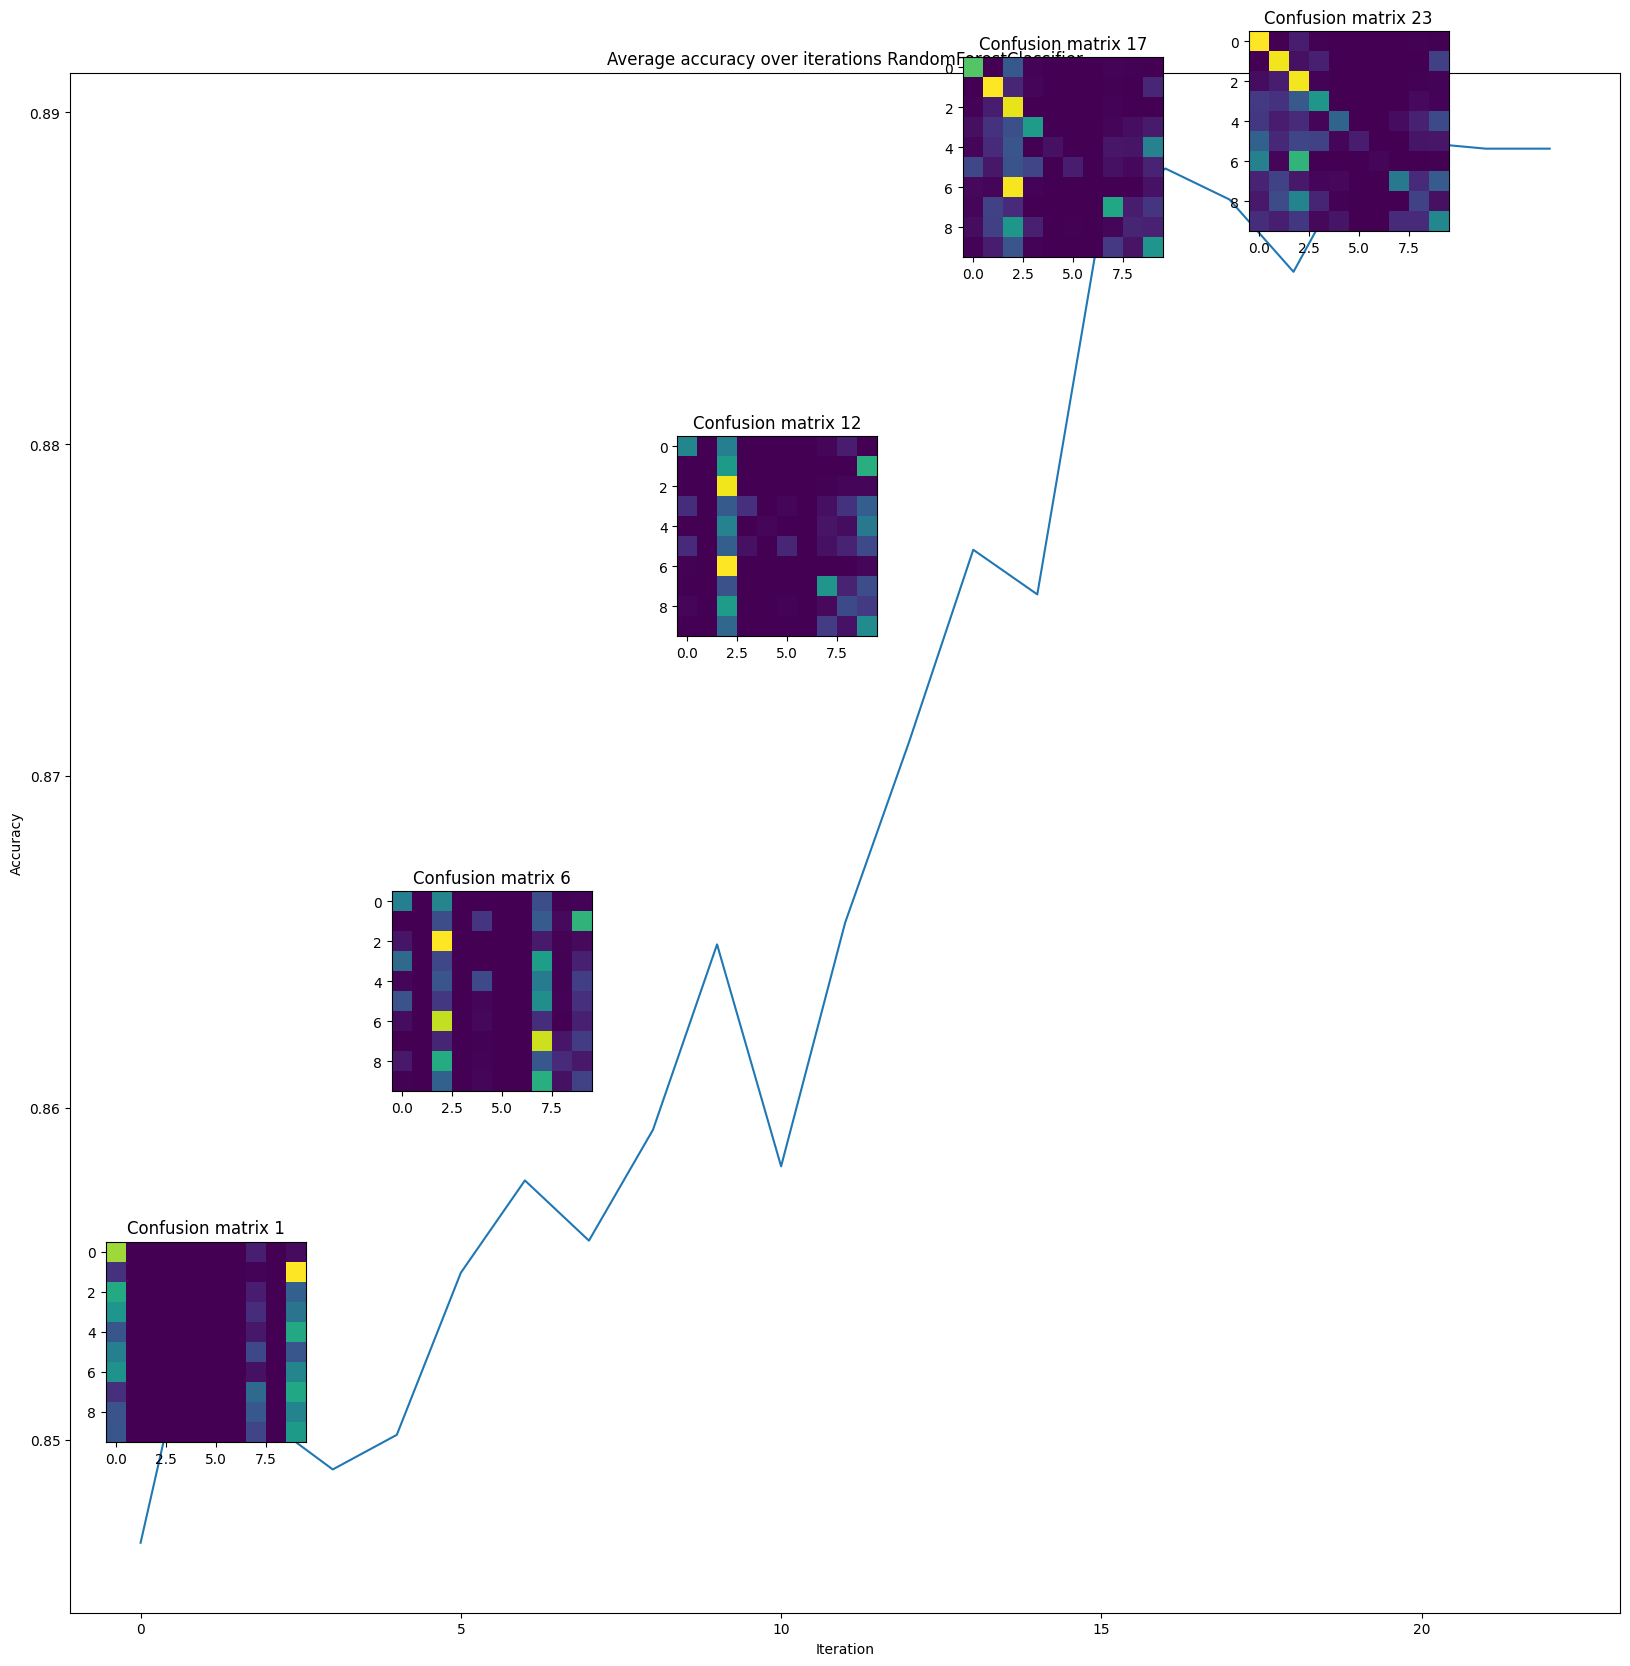

C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid valu

Final accuracy: [0.93025342 0.87096774 0.90813945 0.89291374 0.88668387 0.83897122
 0.92394409 0.93551913 0.80432445 0.90057391]
Final confusion matrix: [[ 565    0   41   78  111  346   63    4  126    9]
 [   0    0   14    3   95  273    7    5 1203    0]
 [   0    0  801   30  131   35   49   15  316    3]
 [  15    0   28  349   31  598    3   13  394    2]
 [   1    0   77    0  997   40   13   18   95   54]
 [  99    0   31  130  172  585    9    7  238    2]
 [   5    0  216    0  209  149  543    0  273    1]
 [  22    0  205    2  205   89    0  923   46   11]
 [   7    0   47   87   29   76    9    6 1090    6]
 [   6    0   61    5  432  129    6  237  318  226]]
Final iteration: 26
Final accuracy threshold reached: True


C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:147: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


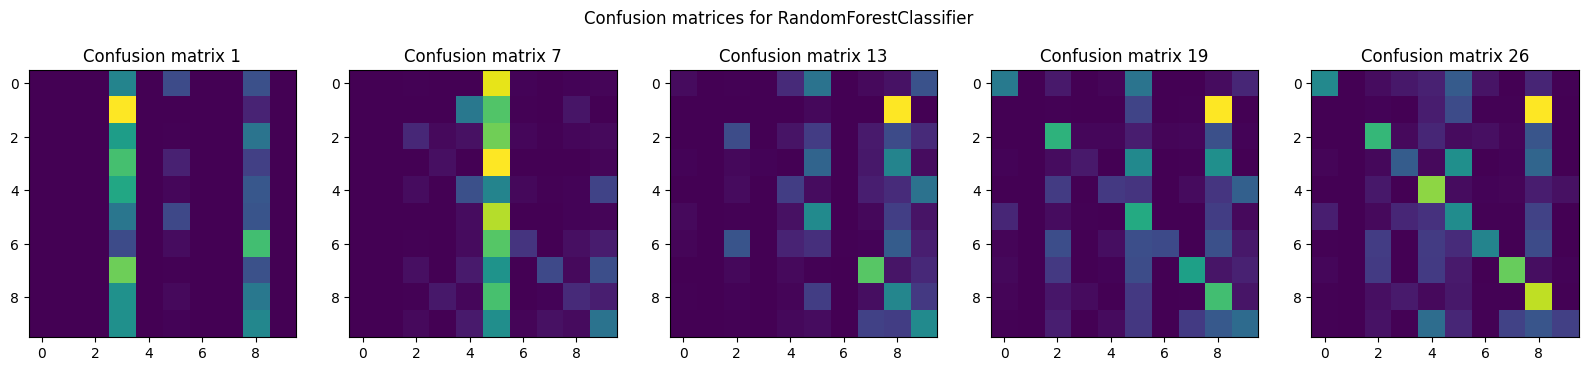

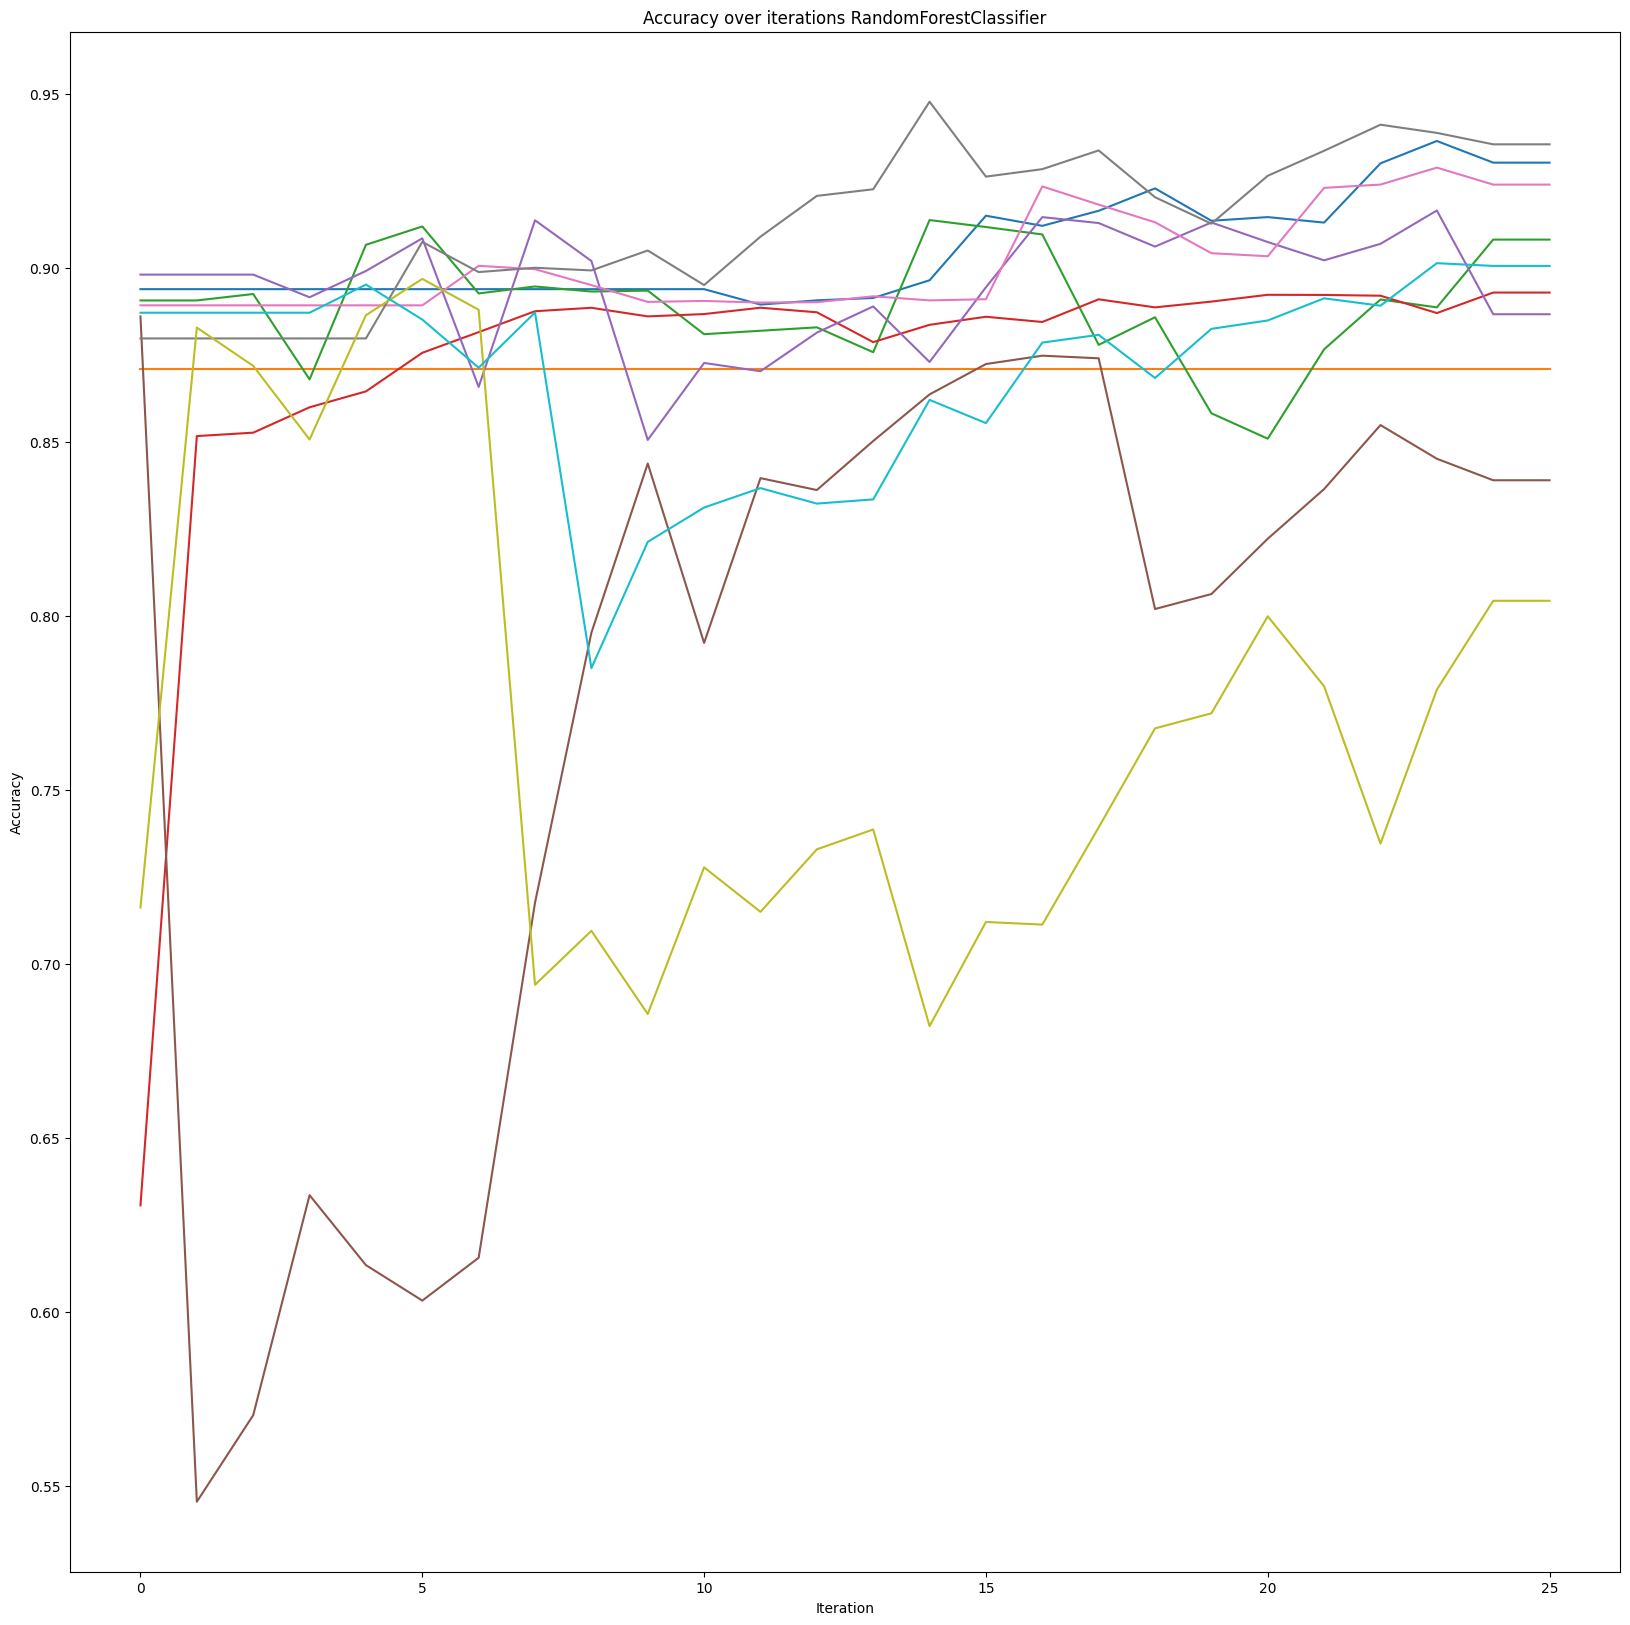

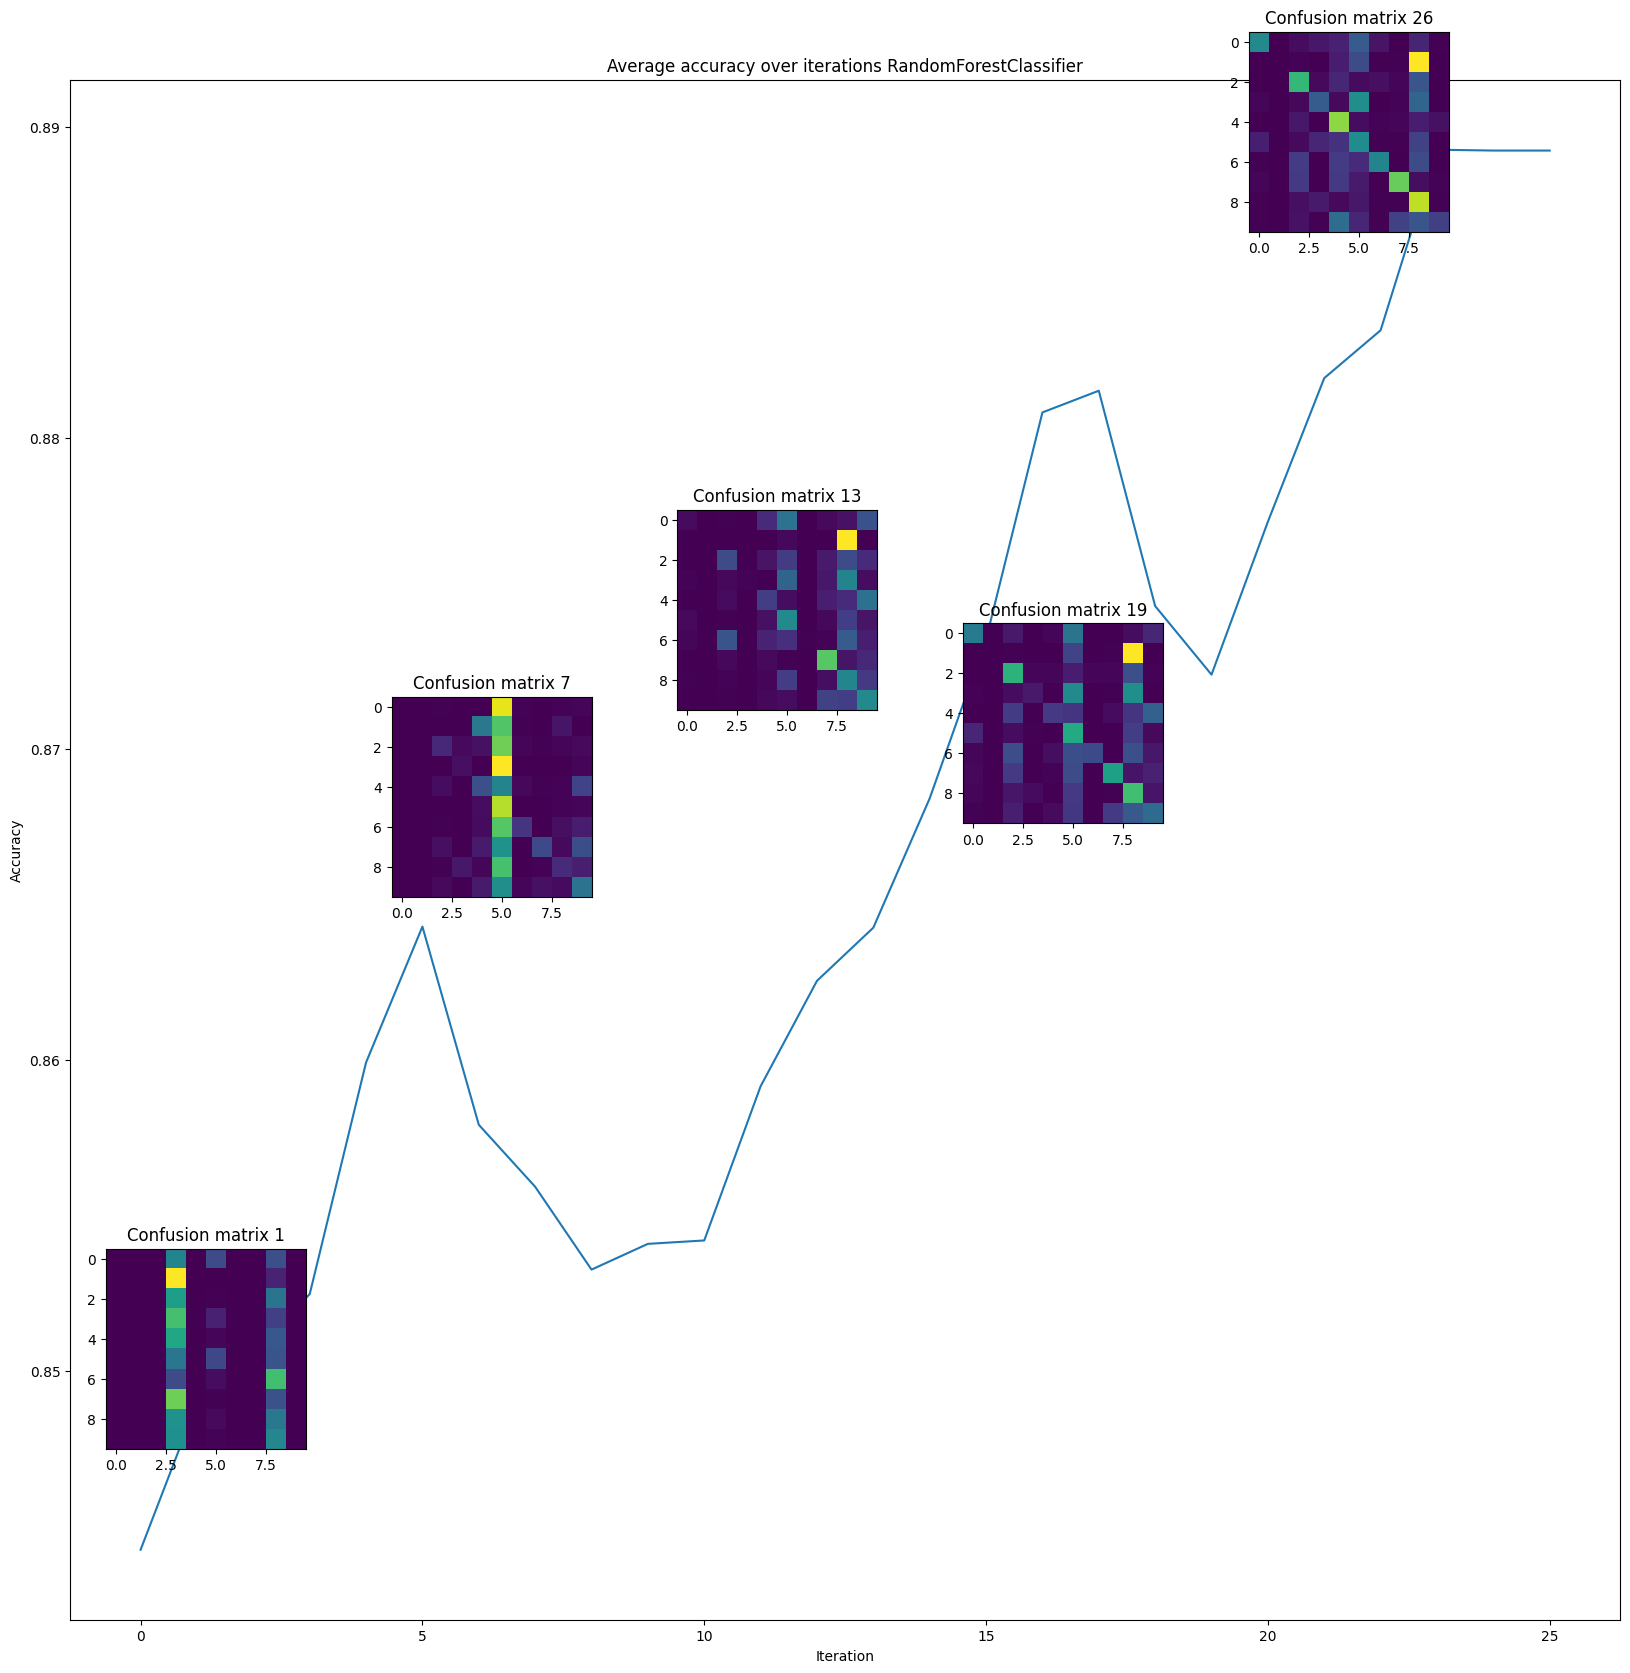

C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
C:\Users\krisr\AppData\Local\Temp\ipykernel_14164\742521498.py:71: RuntimeWarning: invalid valu

KeyboardInterrupt: 

In [61]:

accuracy_threshold = 0.95
max_iterations = 1000
verbose = False
strategies = [None, random_strategy, uncertainty_strategy]
models = [RandomForestClassifier(n_estimators=100, random_state=42), SVC(probability=True, random_state=42)]

for model in models:
    for strategy in strategies:
        active_learner = active_model_learning(model, X, y, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose, strategy_function=strategy)
        active_learner.run()
        active_learner.report()
        figs, axes = active_learner.generate_graphs()
        figs[0].suptitle(f"Confusion matrices for {model.__class__.__name__}\\n{'default strategy' if strategy==None else strategy.__name__} strategy")
        figs[0].savefig(f"confusion_matrices_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.png")
        axes[1].set_title(f"Accuracy over iterations\nactive learning with {model.__class__.__name__} and {'default strategy' if strategy==None else strategy.__name__} strategy")
        figs[1].savefig(f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.png")
        figs[2].savefig(f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}_average.png")
        np.savez(f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.npz", confusion_matrices=active_learner.confusion_matrices, calculable_metrics=active_learner.calculable_metrics, allow_pickle=True)

"""active_learner = active_model_learning(rf_model, X, y, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose)
active_learner.run()
active_learner.report()
figs, axes = active_learner.generate_graphs()
axes[0].set_title(f"Confusion matrices for random forest")
figs[0].savefig("confusion_matrices_rf.png")

axes[1].set_title(f"Accuracy over iterations\nactive learning with random forest and default strategy")
figs[1].savefig("active_learning_rf_default.png")
np.savez("active_learning_rf_default.npz", confusion_matrices=active_learner.confusion_matrices, calculable_metrics=active_learner.calculable_metrics, allow_pickle=True)


"""
